In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import Dataset, DataLoader
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
import gensim

In [22]:
train_data = pd.read_json("./data/train.json")
validation_data = pd.read_json("./data/validation.json")
test_data = pd.read_json("./data/test.json")

### combine train & validation and apply 

In [23]:
# Combine the DataFrames
combined_data = pd.concat([train_data, validation_data], ignore_index=True)

# Determine the size for train and validation sets after combining
train_size = int(len(combined_data) * 0.8)  # Assuming 80% for training and 20% for validation

# Split the combined data back into train and validation DataFrames
train_data = combined_data[:train_size]
validation_data = combined_data[train_size:]

# Resetting index for both DataFrames
train_data.reset_index(drop=True, inplace=True)
validation_data.reset_index(drop=True, inplace=True)

In [49]:
import pandas as pd
from sklearn.model_selection import train_test_split

def split_data_by_class(train_data, validation_data, samples_per_class=200):
    combined_data = pd.concat([train_data, validation_data], ignore_index=True)
    train_data = pd.DataFrame()
    validation_data = pd.DataFrame()
    
    # Iterate through each label
    for label in combined_data['label'].unique():
        # Split data for each label
        label_data = combined_data[combined_data['label'] == label]
        train_label, validation_label = train_test_split(label_data, test_size=300,stratify=label_data['label'])
        
        # Append data to respective train and validation sets
        train_data = pd.concat([train_data, train_label])
        validation_data = pd.concat([validation_data, validation_label])
    
    # Shuffle the data
    train_data = train_data.sample(frac=1).reset_index(drop=True)
    validation_data = validation_data.sample(frac=1).reset_index(drop=True)
    
    return train_data, validation_data
# Assuming you have train_data and validation_data DataFrames
# train_data = pd.read_json("./data/train.json")
# validation_data = pd.read_json("./data/validation.json")

# Split the data by keeping 100 samples of each class in the validation set
train_data, validation_data = split_data_by_class(train_data, validation_data)


In [24]:
# Verify the shapes of train and validation data
print("Train data:", train_data['label'].value_counts())
print("Validation data:", validation_data['label'].value_counts())

Train data: label
3    24030
2    21658
0     2162
1     1088
Name: count, dtype: int64
Validation data: label
3    6248
2    5199
0     504
1     284
Name: count, dtype: int64


In [25]:
train_data['combined_sentences'] = train_data['sentence1'] + " " + train_data['sentence2']
validation_data['combined_sentences'] = validation_data['sentence1'] + " " + validation_data['sentence2']
test_data['combined_sentences'] = test_data['sentence1'] + " " + test_data['sentence2']

C:\Users\allex\AppData\Local\Temp\ipykernel_14424\3168903924.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['combined_sentences'] = train_data['sentence1'] + " " + train_data['sentence2']
C:\Users\allex\AppData\Local\Temp\ipykernel_14424\3168903924.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_data['combined_sentences'] = validation_data['sentence1'] + " " + validation_data['sentence2']


# Preprocessing sentences

In [26]:
import re
import spacy
import spacy.lang.ro.stop_words as stop_words

nlp = spacy.load("ro_core_news_sm")

# Compile the regular expression pattern
pattern = re.compile(r"[^a-zăâîșț@# ]")

# Convert stop words list to a set for faster lookup
sw_set = set(stop_words.STOP_WORDS)
sw_lower = set(word.lower() for word in stop_words.STOP_WORDS)

def text_preparetion(sentence):
    # 1. Lowercase everything
    sentence = sentence.lower()

    # 2. Remove all symbols other than a-z@#.
    sentence = re.sub(pattern, "", sentence)

    # Tokenize the preprocessed sentence
    tokenization = nlp(sentence)

    # 4. Remove stopwords and empty tokens, and perform stemming
    list_text_preprocessed = [
        token.lemma_ for token in tokenization if 
        not token.is_stop and 
        token.pos_ != "SPACE"
    ]
    # for token in tokenization:
    #     print(
    #         f"Text: {token.text}, Lemma: {token.lemma_}, POS Tag: {token.pos_}, Dependency: {token.dep_}, "
    #         f"Stop Word?: {token.is_stop}, Entity Type: {token.ent_type_}"
    #     )
    # Join the stemmed tokens back into a sentence
    processed_text = ' '.join(list_text_preprocessed)

    return processed_text

# Test the function
sentence1 = "Conducerea navală japoneză în ajunul ostilităților era, în general, prudentă și chiar îngrijorată deoarece marina nu primise încă navele de război comandate în februarie 1893, în special navele de..."
text_preparetion(sentence1)
# print(text_preparetion(sentence1))

'conducere naval japonez ajun ostilitate general prudent îngrijorat marină primi încă navă război comanda februarie special navă'

In [27]:
train_data.loc[:, 'preprocessed_sentences'] = train_data['combined_sentences'].apply(text_preparetion)
validation_data.loc[:, 'preprocessed_sentences'] = validation_data['combined_sentences'].apply(text_preparetion)
test_data.loc[:, 'preprocessed_sentences'] = test_data['combined_sentences'].apply(text_preparetion)

C:\Users\allex\AppData\Local\Temp\ipykernel_14424\1785291762.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'preprocessed_sentences'] = train_data['combined_sentences'].apply(text_preparetion)
C:\Users\allex\AppData\Local\Temp\ipykernel_14424\1785291762.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_data.loc[:, 'preprocessed_sentences'] = validation_data['combined_sentences'].apply(text_preparetion)


# Bag of Words

In [42]:
from sklearn.feature_extraction.text import CountVectorizer

#Samples
train_sentences = train_data['preprocessed_sentences']
validation_sentences = validation_data['preprocessed_sentences']
test_sentences = test_data['preprocessed_sentences']

vectorizer = CountVectorizer(min_df=20)

train_vectorized = vectorizer.fit_transform(train_sentences)
validation_vectorized = vectorizer.transform(validation_sentences)
test_vectorized = vectorizer.transform(test_sentences)

train_data['vectorized_sentences'] = [row.toarray()[0].tolist() for row in train_vectorized]
validation_data['vectorized_sentences'] = [row.toarray()[0].tolist() for row in validation_vectorized]
test_data['vectorized_sentences'] = [row.toarray()[0].tolist() for row in test_vectorized]


C:\Users\allex\AppData\Local\Temp\ipykernel_14424\1737353430.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['vectorized_sentences'] = [row.toarray()[0].tolist() for row in train_vectorized]
C:\Users\allex\AppData\Local\Temp\ipykernel_14424\1737353430.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_data['vectorized_sentences'] = [row.toarray()[0].tolist() for row in validation_vectorized]


# SAVE PREPROCESSED DATAFRAMES

In [6]:
train_data.to_csv('./data/dataframes/train_data_text.csv', index=False)
validation_data.to_csv('./data/dataframes/validation_data_text.csv', index=False)
test_data.to_csv('./data/dataframes/test_data_text.csv', index=False)

# LOAD PREPROCESSED DATAFRAMES

In [2]:
# Load DataFrames from CSV files
train_data = pd.read_csv('./data/dataframes/train_data_text.csv')
validation_data = pd.read_csv('./data/dataframes/validation_data_text.csv')
test_data = pd.read_csv('./data/dataframes/test_data_text.csv')

In [5]:
train_data.head()

,sentence1,sentence2,label,guid,combined_sentences,preprocessed_sentences,vectorized_sentences
0,Primul taragotist român a fost Nicolae Luță Io...,"Colegiul de arhitectură, artă și planificare (...",3,7cec5ac4-c115-4976-8d2a-9badfe9b63b9,Primul taragotist român a fost Nicolae Luță Io...,taragotist român nicolae luță ioviță originar ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Lupta revoluționarilor este condusă de Avram I...,Schiul nordic face parte din programul olimpic...,3,bc2fa29f-cf22-4a7c-8b55-9b1ed019f6ac,Lupta revoluționarilor este condusă de Avram I...,lupta revoluționarilor condusă avram iancu ioa...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Locuitorii liberi au devenit „''iobagiones cas...,"În anii 1960, ea a apărut în drame realizate l...",3,8547b1ef-7bfe-43a9-aedf-bad0c0fbc049,Locuitorii liberi au devenit „''iobagiones cas...,locuitorii liberi devenit iobagiones castri io...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,În anul 2002 are loc lansarea în domeniul turi...,Se lansează primul hotel al grupului în otopen...,2,0ad1ce19-7aa9-4ddd-b8d6-822072a723b0,În anul 2002 are loc lansarea în domeniul turi...,anul loc lansarea domeniul turistichotelier la...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"Zillich a mijlocit, prin revista ''Klingsor'',...","Au apărut lucrări ale lui ion luca caragiale, ...",2,50c44ffa-b0c1-4d98-bc6c-3bbf95f50896,"Zillich a mijlocit, prin revista ''Klingsor'',...",zillich mijlocit revista klingsor debutul mult...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


# Bag of Words Dataset

In [43]:
max_len = len(vectorizer.vocabulary_)

class BagOfWordsDataset(Dataset):
    def __init__(self, data, train=True):
        super().__init__()
        self.train = train
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        sentence_vector = row['vectorized_sentences']
        # sentence_vector = torch.tensor(sentence_vector, dtype=torch.float32) # for network1
        sentence_vector = torch.tensor(sentence_vector, dtype=torch.long) # for network2
        label = row['label']
        label = torch.tensor(label, dtype=torch.long)
        if self.train:
            return sentence_vector, label
        else:
            return sentence_vector, row['guid']

In [44]:
train_dataset =  BagOfWordsDataset(data=train_data)
validation_dataset = BagOfWordsDataset(data=validation_data)
test_dataset = BagOfWordsDataset(data=test_data, train=False)

In [45]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Tokenizer Dataset

In [112]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

# tokenizer = get_tokenizer(tokenizer="spacy", language='ro_core_news_sm')

max_len = max(len(sentence.split(" ")) for sentence in train_data['preprocessed_sentences'])
tokenized_sentences = [sentence.split(" ") for sentence in train_data['preprocessed_sentences']]
vocab = build_vocab_from_iterator(tokenized_sentences)


def numericalize_sentence(sentence):
    tokens = sentence.split(" ")
    # return torch.tensor([vocab[token] for token in tokens], dtype=torch.float32) # for network 1
    return torch.tensor([vocab[token] for token in tokens], dtype=torch.long) # for network 2


class CustomDataset(Dataset):
    def __init__(self, data, train=True):
        super().__init__()
        self.train = train
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        sentence = row['preprocessed_sentences']
        numericalized = numericalize_sentence(sentence)
        
        # Pad shorter sentences
        if len(numericalized) < max_len:
            padding_length = max_len - len(numericalized)
            pad_tensor = torch.full((padding_length,), vocab['<pad>'], dtype=torch.long)
            numericalized = torch.cat((numericalized, pad_tensor), dim=0)
        
        # Truncate longer sentences
        elif len(numericalized) > max_len:
            numericalized = numericalized[:max_len]
            
        if self.train:
            label = row['label']
            return numericalized, torch.tensor(label, dtype=torch.long)
        else:
            return numericalized, row['guid']

48938lines [00:00, 370955.58lines/s]


In [113]:
train_dataset = CustomDataset(data=train_data)
validation_dataset = CustomDataset(data=validation_data)
test_dataset = CustomDataset(data=test_data, train=False)

In [114]:
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 1. SentenceClassifier - only 1 layer

In [95]:
class SentenceClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SentenceClassifier, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # print(x.shape)
        x = self.fc(x)
        x = self.softmax(x)
        # print(x.shape)
        return x

In [46]:
input_dim = max_len
print(input_dim)
output_dim = 4  # Number of output classes
model = SentenceClassifier(input_dim, output_dim)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = ExponentialLR(optimizer, gamma=0.9)
num_epochs = 5

6951


NameError: name 'SentenceClassifier' is not defined

Epoch 1/5 - Loss: 1.1144 - Val Loss: 1.0818 - Time = 55.0s
Epoch 2/5 - Loss: 1.0239 - Val Loss: 1.0800 - Time = 54.6s
Epoch 3/5 - Loss: 0.9963 - Val Loss: 1.0817 - Time = 54.8s
Epoch 4/5 - Loss: 0.9787 - Val Loss: 1.0836 - Time = 55.0s
Epoch 5/5 - Loss: 0.9667 - Val Loss: 1.0848 - Time = 55.2s

Training finished!


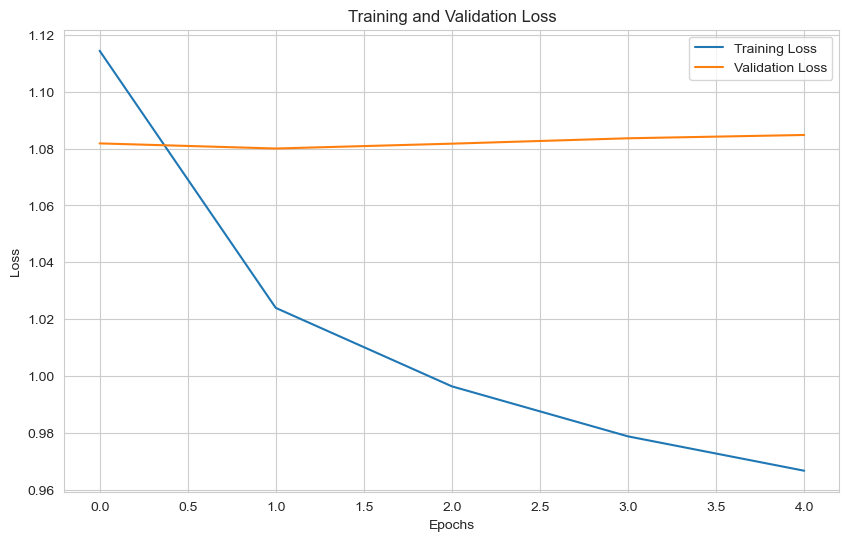

In [99]:
training_method(model, criterion, optimizer, scheduler, num_epochs)

### 2. ImprovedSentenceClassifier - embedded - bidirectional LSTM - hidden - output

In [47]:
import torch
import torch.nn as nn

class ImprovedSentenceClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout_prob=0.2):
        super(ImprovedSentenceClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.dropout = nn.Dropout(dropout_prob)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim )  # Multiplying by 2 for bidirectional
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim , output_dim)
        # self.fc_out = nn.Linear(hidden_dim , output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = torch.mean(x, dim=1)  # Mean pooling
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.dropout(x)
        # x = self.relu(x)
        x = self.fc2(x)
        # x = self.fc_out(x)
        x = self.softmax(x)
        return x


In [48]:
# vocab_size = len(vocab)
vocab_size = max_len
embedding_dim = 64  # embedding dimension
hidden_dim = 32      # hidden layer dimension
output_dim = 4       # number of classes
droput_prob = 0.5    # dropout procentage
model = ImprovedSentenceClassifier(vocab_size, embedding_dim, hidden_dim, output_dim, droput_prob)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)
scheduler = ExponentialLR(optimizer, gamma=0.9, verbose=True)
num_epochs = 10

Adjusting learning rate of group 0 to 1.0000e-02.


In [50]:
training_method(model, criterion, optimizer, scheduler, num_epochs)

Adjusting learning rate of group 0 to 9.0000e-03.
Epoch 1/10 - Loss: 1.2083 - Val Loss: 1.1956 - Time = 106.1s
Adjusting learning rate of group 0 to 8.1000e-03.
Epoch 2/10 - Loss: 1.2501 - Val Loss: 1.2330 - Time = 109.2s
Adjusting learning rate of group 0 to 7.2900e-03.
Epoch 3/10 - Loss: 1.2521 - Val Loss: 1.2330 - Time = 108.0s
Adjusting learning rate of group 0 to 6.5610e-03.
Epoch 4/10 - Loss: 1.2530 - Val Loss: 1.2330 - Time = 105.4s
Adjusting learning rate of group 0 to 5.9049e-03.
Epoch 5/10 - Loss: 1.2531 - Val Loss: 1.2330 - Time = 104.1s


KeyboardInterrupt: 

### test models input/output

In [112]:
# dummy_input = torch.randint(0, 10, (1024, max_len), dtype=torch.float32) # reteaua 1
dummy_input = torch.randint(0, 10, (256, max_len), dtype=torch.long) # reteaua 2
dummy_input = dummy_input.to(device)

output = model(dummy_input)
# torch.Size([1024, 4]) # reteaua 1
# torch.Size([1024, 1026, 4]) # reteaua 2
print(output.shape)

torch.Size([256, 4])


# Training method

In [49]:
def training_method(model, criterion, optimizer, scheduler, num_epochs):
    import time
    import matplotlib.pyplot as plt
    
    train_losses = []  # List to store training losses
    val_losses = []  # List to store validation losses
    
    for epoch in range(num_epochs):
        start = time.time()

        ### TRAINING
        model.train()
        training_loss = 0.0
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            training_loss += loss.item()
            
        train_loss = training_loss / len(train_loader)
        train_losses.append(train_loss)
        
        ### VALIDATING
        model.eval()
        validation_loss = 0.0
        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                output = model(inputs)
                loss = criterion(output, labels)
                validation_loss += loss.item()
                
        val_loss = validation_loss / len(validation_loader)
        val_losses.append(val_loss)
        
        scheduler.step()
        
        end = time.time()

        print(f"Epoch {epoch + 1}/{num_epochs} - Loss: {train_loss:.4f} - "
              f"Val Loss: {val_loss:.4f} - "
              f"Time = {end - start:.1f}s\n")

    print('Training finished!')

    # Plotting the losses over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

# Testing

#### compute predicted_labels

In [ ]:
from sklearn.metrics import f1_score

with torch.no_grad():
    total = 0
    correct = 0
    true_labels = []
    predicted_labels = []

    for inputs, labels in validation_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        output = model(inputs)

        _, predicted = torch.max(output, 1)
        predicted_labels.extend(predicted.cpu().tolist())
        true_labels.extend(labels.cpu().tolist())
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    accuracy = correct / total
    print(f"Validation Accuracy: {accuracy:.4f}")

    f1_macro = f1_score(true_labels, predicted_labels, average='macro')
    print(f"Macro-average F1 score: {f1_macro:.4f}")

#### classification report

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(true_labels, predicted_labels, zero_division=0)
print(report)

#### heatmap

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels, predicted_labels)

class_labels = ['Class 0', 'Class 1', 'Class 2', 'Class 3']

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


# Generate submission

In [20]:
with torch.no_grad():
    all_outputs = []
    all_guids = []
    for inputs, batch_guids in test_loader:
        inputs = inputs.to(device)
        output = model(inputs)
        _, output = torch.max(output, 1)
        all_outputs.extend(output)
        all_guids.extend(batch_guids)


In [21]:
# Convert lists to DataFrame
all_outputs_cpu = [output.cpu().detach().numpy() for output in all_outputs]

# Convert lists to DataFrame
data = {'guid': all_guids, 'label': all_outputs_cpu}
df = pd.DataFrame(data)

# Save DataFrame to CSV
df.to_csv('./data/submissions/output.csv', index=False)

print("CSV file saved successfully.")

CSV file saved successfully.
